Description
======
This file aims to map two genome assemblies and find out how many gaps are filled in the new assembly compared to old assembly.
Since somes files are too large to upload in github, we have backed up them in google drive here. You can download it and then change the folder parameter to the path of it.
To run this code, you need to install MUMmer. And some python modules in the following cell.

In [5]:
%matplotlib inline  
from Bio import SeqIO
from pybedtools import BedTool
from collections import Counter
import sarge
import re
import multiprocessing as mp
from natsort import natsorted
import glob,os
import pandas as pd
import sarge,sys
import numpy as np
from joblib import Parallel,delayed
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('ggplot')
from IPython.display import display
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import pysam


The followings are parameters you need to define when running the code
--------------------------------------------------------------------------------

In [8]:
#================== Define some paramters
folder = '/data/shangzhong/Picr_assembly/fill_gap'  # path to the folder you downloaded from google drive
nucmer_dir = folder + '/nucmer'
old_fa = folder + '/genomes/hamster.fa'
new_fa = folder + '/genomes/picr.fa'
new_gff = folder + '/genomes/picr.gff3'#'/genomes/picr_maddy.gff'
chr_len_fn = folder + '/genomes/picr.fa.fai'
human_id_fn = folder + '/genomes/gencode22_human_ID_Symbol.txt'
ref_super_pos_map = folder + '/genomes/picr_super_chr_pos.txt'
VCF_path = folder + '/VCF'
thread = 9

### 1. we align old genome to new genome using nucmer from MUMmer, since there is no parallel option in nucmer, we split the old genome into multiples files. Each file has one scaffold. After that results were merged into one file.

#### Some functions to run nucmer

In [3]:
#===============================================================================
#                     1. Compare old and new genome using MUMmer to find gap region in old genome
#===============================================================================
def split_fa(fa):
    # split fa file
    n = 0
    for record in SeqIO.parse(fa,'fasta'):
        fn = 'file'+str(n)+'.fa'
        with open(fn,'w') as f:
            SeqIO.write(record,f,'fasta')
        n += 1
        
def nucmer(ref,query):
    cmd = ('nucmer -maxmatch -l 60 -c 90 -p {pre} {r} {q}').format(pre=ref[:-3],r=ref,q=query) # 
    print(cmd)
    sarge.run(cmd)

def dnadiff(delta):
    cmd = ('dnadiff -d {delta}').format(delta=delta)
    print(cmd)
    sarge.run(cmd)

def main_nucmer(path,ref_fa,query_fa):
    if not os.path.exists(path): os.mkdir(path)
    os.chdir(path)
    # run nucmer
    if not os.path.exists('result.delta'):
        cmd = ('nucmer -p result -l 60 -c 90 {ref} {qry}').format(ref=ref_fa,qry=query_fa)
        sarge.run(cmd)
    # run generate out.1coords
    if not os.path.exists('out.1coords'):
        dnadiff('result.delta')

#### run NUCmer

In [4]:
#==================== 1. run nucmer
nucmer_dir = folder + '/nucmer'
main_nucmer(nucmer_dir,new_fa,old_fa)

### 2. We extract gap regions in old genome and output into a file that has 4 columns: [scaffold name,gap start position, gap end position, length of gap]. Position is 0 based.

#### some functions to extract gap regions

In [5]:
#===============================================================================
#                     2. get start and end position of N in genome
#===============================================================================
def get_N_in_genome(fa,N_pos_file):
    '''This function gets start and end position of N that separate scaffolds in merged
    super scaffold 
    '''
    with open(N_pos_file,'w') as out_h:
        with open(fa) as handle:
            for record in SeqIO.parse(handle, "fasta"):
                for match in re.finditer('N+', str(record.seq)):
                    out_h.write('\t'.join([record.id, str(match.start()),str(match.end())])+'\n')
    # add length column
    df = pd.read_csv(N_pos_file,sep='\t',names=['chr','start','end'])
    df['len'] = df['end']-df['start']
    df.to_csv(N_pos_file,sep='\t',index=False)
    return df

#### run code to get gap region in old genome

there are 97518 short gaps representing 58.6920410227  percent of total gaps
there are 520 short gaps representing 16.0791589363  percent of total gaps
there are 97518 short gaps representing 58.6920410227  percent of total gaps
there are 520 short gaps representing 16.0791589363  percent of total gaps
CPU times: user 5.36 s, sys: 816 ms, total: 6.18 s
Wall time: 5.25 s


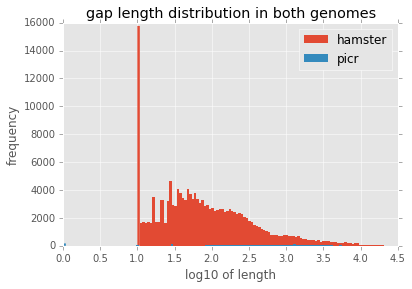

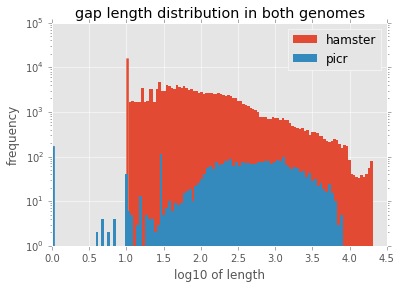

In [16]:
%%time
#==================== 2. get start and end position of N in old genome =======
# files
qry_N_pos_file = folder + '/01_old_N_pos.txt' 
ref_N_pos_file = folder + '/01_new_N_pos.txt'
# code
def plot_gap_len_dist(fa,pos_file,figure,title,log=False):
    '''plot the gap length distribution
    '''
    if not os.path.exists(pos_file):
        ref_df = get_N_in_genome(fa,pos_file)
        ref_df.head()
    if os.path.exists(pos_file):
        q_N_pos_df = pd.read_csv(pos_file,sep='\t',header=0)
        n = q_N_pos_df[q_N_pos_df['len'].values <= 90].shape[0]
        print 'there are',n,'short gaps','representing',float(n)/q_N_pos_df.shape[0]*100,' percent of total gaps'
#         _ = plt.figure()
        ax = np.log10(q_N_pos_df['len']).plot(kind='hist',bins=100,title=title,edgecolor='none')
        _ = ax.set_xlabel('log10 of length')
        _ =ax.set_ylabel('frequency')
        _ =ax.set_xlim([0,4.5])
        if log==True:
            _ = ax.set_yscale('log')
        else:
            pass

def wrap_plot_dist(old_fa,new_fa,qry_N_pos_file,ref_N_pos_file,figure,log=False):
    '''plot both old and new genome gap length distribution in one figure'''
    title = 'gap length distribution in both genomes'
    plot_gap_len_dist(old_fa,qry_N_pos_file,figure,title,log)
    plot_gap_len_dist(new_fa,ref_N_pos_file,figure,title,log)
    plt.legend(['hamster','picr'])
    plt.savefig(figure,dpi=300)

plt.figure()
figure = folder + '/f01_gap_len_distribution.svg'
wrap_plot_dist(old_fa,new_fa,qry_N_pos_file,ref_N_pos_file,figure,log=False)
plt.figure()
figure = folder + '/f02_gap_len_distribution_log.svg'
wrap_plot_dist(old_fa,new_fa,qry_N_pos_file,ref_N_pos_file,figure,log=True)

### 3. After getting gap regions in old genome, we then try to find their corresponding regions in the new genome. Gap region doesn't map anywhere, but if the left and right fragments of gap maps to the new genome with simliar distance to gap lengh, then we are confident to determine the corresponding gap region in the new gennome. The all kinds of mapping situations around gap region is shown in the following figure.

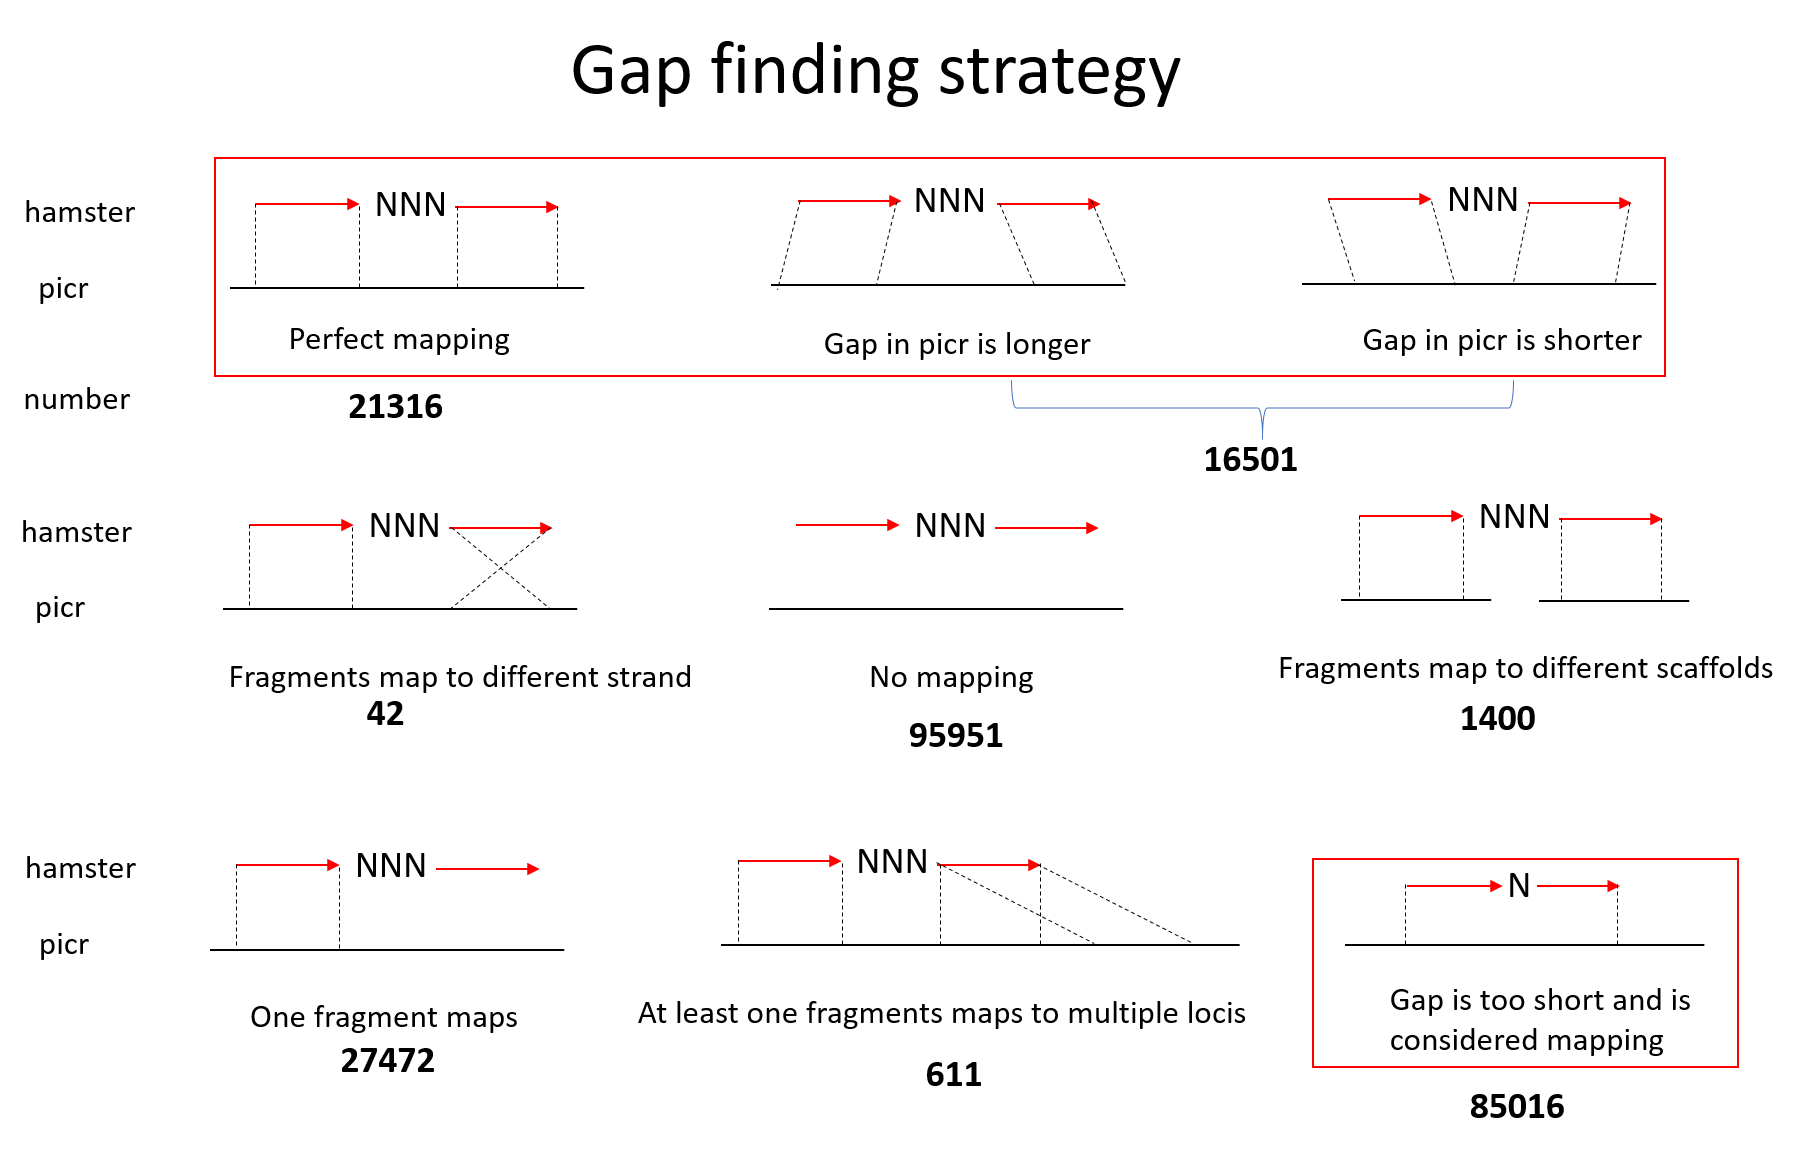

In [9]:
from IPython.core.display import Image
Image(filename = folder + "/gap_finding_strategy.png", width=600, height=500)

In [16]:
#===============================================================================
#                     2. get distance to nearest mapping fragments from gaps
#===============================================================================
def get_dist_to_nearest_map(row,scaff_mcoord_df):
    '''get distance to nearest mapping fragments on both sides of gaps
    * scaff_mcoord_df: dataframe output from dnadiff. default file name is: out.1coords
    * row: row of the gap dataframe in the file 01_hamster_N_pos.txt.
    '''
    start = int(row['start'])
    end = int(row['end'])
    scaffold = row['chr']
    scaff_mcoord_df = scaff_mcoord_df.reset_index(drop=True)
    if scaff_mcoord_df.shape[0] == 0:
        return pd.Series(['0']*3)
    scaff_e = scaff_mcoord_df['q_start'].tolist()[1:]
    scaff_s = scaff_mcoord_df['q_end'].tolist()[:-1]
    strand = scaff_mcoord_df['que_strand'].tolist()
    chrom = scaff_mcoord_df['ref'].tolist()
    for i in range(len(scaff_s)):
        if start >= scaff_s[i] and end <= scaff_e[i]: # start,end are gap pos, s,e are out.1coord pos
            pro_dist = start - scaff_s[i]+1
            epi_dist = scaff_e[i] - end
            map_scaffold = ','.join(list(set(chrom[i:i+2])))
            return pd.Series([map_scaffold,str(pro_dist),str(epi_dist)])
    return pd.Series(['0']*3)

def get_df_dist_to_nearest_map(q_gap_df):
    '''this function gets gap positions in reference for all the gaps in query
    * q_gap_df: gap position. has 4 columns: ['chr','start','end','len']
    '''
    global out1coord_df
    scaff = q_gap_df['chr'].tolist()[0]
    scaff_map_df = out1coord_df[out1coord_df['query'].values==scaff]
    q_gap_df[['ref_chr','pro_dist','epi_dist']] = q_gap_df.apply(lambda row: get_dist_to_nearest_map(row,scaff_map_df),axis=1)
    return q_gap_df

def applyParallel(dfGrouped,func,thread):
    retLst = Parallel(thread)(delayed(func)(group) for name,group in dfGrouped)
    return pd.concat(retLst)


In [18]:
%%time
out1coord = nucmer_dir + '/out.1coordsbyqry'
qry_N_pos_file = folder + '/01_old_N_pos.txt' 
gap_dist_pos_fn = folder + '/02_map_dist_to_gap_pos.txt'
if not os.path.exists(gap_dist_pos_fn):
    # 1. read mummer coordinate file and hamster gap position file
    out1coord_df = pd.read_csv(out1coord,sep='\t',header=None,names=['r_start','r_end','q_start','q_end', 
                                     'r_m_len','q_m_len','m_perc','r_len','q_len','r_perc','q_perc','ref','query'])
    out1coord_df['que_strand'] = out1coord_df.apply(lambda row: '+' if int(row['q_start']) < int(row['q_end']) else '-',axis=1)
    out1coord_df[['q_start','q_end']] = out1coord_df.apply(lambda row: pd.Series([min(row['q_start'],row['q_end']),
                                                                      max(row['q_start'],row['q_end'])]),axis=1)
    h_n_df = pd.read_csv(qry_N_pos_file,sep='\t',header=0,names=['chr','start','end','len'])
    # 2. get gap position
    gap_dist_df = applyParallel(h_n_df.groupby(['chr']),get_df_dist_to_nearest_map,thread)
    gap_dist_df.columns = ['qry','q_s','q_e','q_len','ref_chr','pro_dist','epi_dist']
    gap_dist_df.to_csv(gap_dist_pos_fn,sep='\t',index=False)

CPU times: user 2min 6s, sys: 1.63 s, total: 2min 8s
Wall time: 2min 38s


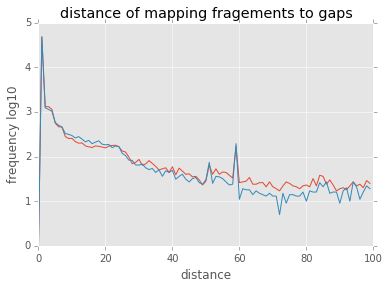

In [5]:
gap_dist_pos_fn = folder + '/02_map_dist_to_gap_pos.txt'
if os.path.exists(gap_dist_pos_fn):
    gap_dist_df = pd.read_csv(gap_dist_pos_fn,sep='\t',header=0)
    gap_dist_df['pro_dist'] = gap_dist_df['pro_dist'].astype('int')
    gap_dist_df['epi_dist'] = gap_dist_df['epi_dist'].astype('int')
    # for i in range(10,11):
    #     test = gap_df[(((gap_dist_df['pro_dist']<=i) & (gap_dist_df['epi_dist']<=i) & \
    #                     (gap_dist_df['epi_dist']>0) & (gap_dist_df['pro_dist']>0) )) & \
    #                   (~gap_dist_df['ref_chr'].str.contains(','))]
    #     print test.shape[0]
    # display(test)
    test = gap_dist_df[(~gap_dist_df['ref_chr'].str.contains(',')) & \
                       (~((gap_dist_df['epi_dist']==0) & (gap_dist_df['pro_dist']==0)))]
    pro = Counter(test['pro_dist'])
    epi = Counter(test['epi_dist'])
    x = range(100)#range(max(max(test['r_s']),max(test['r_e'])))
    pro_f = [np.log10(pro[i]) if i in pro else 0 for i in x]
    epi_f = [np.log10(epi[i]) if i in epi else 0 for i in x]
    _ = plt.plot(x,pro_f,label='pro_dist')
    _ = plt.plot(x,epi_f,label='epi_dist')
    _ = plt.title('distance of mapping fragements to gaps')
    _ = plt.xlabel('distance')
    _ = plt.ylabel('frequency log10')

#### Functions to find corresponding regions of gap regions.

In [27]:
#===============================================================================
#                     3. get corresponding gap regions of old genome gaps
#===============================================================================
def get_gap_pos_in_ref(row,scaff_mcoord_df):
    '''get gap position mapping between old genome and new genome
    this function only process one line of the query gap.
    * scaff_mcoord_df: dataframe output from dnadiff. default file name is: out.1coords
    * row: row of the gap dataframe in the file 01_hamster_N_pos.txt.
    '''
    start = int(row['start'])
    end = int(row['end'])
    scaffold = row['chr']
    scaff_mcoord_df = scaff_mcoord_df.reset_index(drop=True)
    if scaff_mcoord_df.shape[0] == 0:
        return pd.Series(['0']*4)
    # add strand information and switch start and end for '-' strand
    scaff_mcoord_df['que_strand'] = scaff_mcoord_df.apply(lambda row: '+' if int(row['q_start']) < int(row['q_end']) else '-',axis=1)
    q_strand = list(set(scaff_mcoord_df['que_strand'].tolist()))
    if len(q_strand)>1:
        pass
    pro_log = scaff_mcoord_df.apply(lambda r: abs(min(r['q_start'],r['q_end'])+1-end)<=10,axis=1)  # first fragment mapping
    epi_log = scaff_mcoord_df.apply(lambda r: abs(max(r['q_start'],r['q_end'])-1-start)<=10,axis=1)  # second fragment mapping
    if pro_log.tolist().count(True) == 2 or epi_log.tolist().count(True) == 2:
        return pd.Series(['2']*3 + ['2_pro/epi map twice'])
    cri = pro_log | epi_log 
    ref_gap_df = scaff_mcoord_df[cri]
    if ref_gap_df.shape[0] == 0:
        return pd.Series(['0']*4)   #'gap not found'
    elif ref_gap_df.shape[0] == 1:
        return pd.Series(['1']*4)   # 'one fragment map'
    elif ref_gap_df.shape[0] == 2:
        q_strand = list(set(ref_gap_df['que_strand'].tolist()))
        ref = list(set(ref_gap_df['ref'].tolist()))
        if len(ref) > 1:
            return pd.Series(['2']*3+['2_double scaffold'])
        else:
            ref = ref[0]
        if len(q_strand) == 2:
            return pd.Series(['2']*3+['2_diff orientation'])  #'fragments map to opsite strand'    # 1st type of output
        else:
            gap_pos = []
            for s,e in zip(ref_gap_df['r_start'],ref_gap_df['r_end']):
                gap_pos.extend([s,e])
            if gap_pos[0]<gap_pos[2]<gap_pos[1] or gap_pos[0]<gap_pos[3]<gap_pos[1]:
                return  pd.Series(['2']*3+['2_overlap']) #'fragments overlap'
            else:
                r_dist = abs(gap_pos[2]-gap_pos[1])
                q_dist = end - start 
#                 min_dist = min(r_dist,q_dist)
                if r_dist>q_dist: #abs(r_dist-q_dist)/float(min_dist) > 0.5:
                    sentence = 'picr gap is longer'
                elif r_dist<q_dist:
                    sentence = 'picr gap is shorter'
                else:
                    sentence = 'picr gap is the same'
                return pd.Series([ref,str(min(gap_pos[1:3])-1),str(max(gap_pos[1:3])),sentence])
    elif ref_gap_df.shape[0] > 2:
        return pd.Series(['3']*4) #'at least one fragment map to more than one place'

def get_df_gap_pos_in_ref(q_gap_df):
    '''this function gets gap positions in reference for all the gaps in query
    * q_gap_df: gap position. has 4 columns: ['chr','start','end','len']
    '''
    global out1coord_df
    scaff = q_gap_df['chr'].tolist()[0]
    scaff_map_df = out1coord_df[out1coord_df['query'].values==scaff]
    q_gap_df[['ref_chr','r_g_start','r_g_end','gap_type']] = q_gap_df.apply(lambda row: get_gap_pos_in_ref(row,scaff_map_df),axis=1)
    return q_gap_df

def applyParallel(dfGrouped,func,thread):
    retLst = Parallel(thread)(delayed(func)(group) for name,group in dfGrouped)
    return pd.concat(retLst)

#### find corresponding gap regions

In [29]:
%%time
out1coord = nucmer_dir + '/out.1coords'
qry_N_pos_file = folder + '/01_old_N_pos.txt' 
gap_pos_fn = folder + '/03_gap_pos.txt'
if not os.path.exists(gap_pos_fn):
    # 1. read mummer coordinate file and hamster gap position file
    out1coord_df = pd.read_csv(out1coord,sep='\t',header=None,names=['r_start','r_end','q_start','q_end', 
                                     'r_m_len','q_m_len','m_perc','r_len','q_len','r_perc','q_perc','ref','query'])
    h_n_df = pd.read_csv(qry_N_pos_file,sep='\t',header=0,names=['chr','start','end','len'])
    # 2. get gap position
    gap_df = applyParallel(h_n_df.groupby(['chr']),get_df_gap_pos_in_ref,thread)
    gap_df.columns = ['qry','q_s','q_e','q_len','ref','r_s','r_e','gap_type']
    gap_df.to_csv(gap_pos_fn,sep='\t',index=False)

CPU times: user 40.2 s, sys: 1.39 s, total: 41.5 s
Wall time: 13min 48s


### 4. When MUMmer aligns the genome, if two mapping fragments are less than 90 bps away, it merge them into one large fragment. Thus the gap regions would be considered as mapping and the previous method cannot find the corresponding gaps. Therefore we parse the alignment file to extract these small gap regions.

### functions to find corresponding small gap regions

In [31]:
#===============================================================================
#                     4. get corresponding gap position of short (<90) hamster gaps
#===============================================================================
def get_ref_gap(ali_fn,map_line):
    '''this function gets corresponding reference gap region given the query gap region and 
       mapping between query and reference
    * ali_fn: mapping results of a query to reference using show-align function of mummer
    * map_line: a row results from getting overlap between query gap region and mapping results
                example line: NW_006868509.1 11915 11973 58 NW_006868509.1 6413 16359 9947 picr_40 458738 468713 9976 58
    '''
    item = map_line#.split('\t')
    que = item[0]
    gap_s = int(item[1])
    gap_e = int(item[2])
    p_ali_fn = '/'.join(ali_fn.split('/')[:-1]) + '/' + que + '_' + str(item[1])
    # extract the pairwise mapping
    cmd = ('sed -n \'/{start}/,/{start}/p\' {in_fn} > {out}').format(start=str(item[9])+' - '+str(item[10]),in_fn=ali_fn,out=p_ali_fn)
    sarge.run(cmd)
    with open(p_ali_fn) as f:
        n = 0
        q_pos = []
        r_pos = []
        for line in f:
            if line.startswith('\n') or line.startswith(' '):
                continue
            elif line.startswith('-'):
                if '| +1' in line:
                    step = 1
                else:
                    step = -1
                continue
            else:
                n += 1
                if n%2 == 1:
                    l = line.strip().split()
                    r_seq = l[1]
                    r_s = int(l[0])
#                     r_e = r_s + len(l[1]) - l[1].count('.')
                if n%2 == 0:
                    l = line.strip().split()
                    q_seq = l[1]
                    q_s = int(l[0])
                    q_e = q_s + len(l[1])*step - l[1].count('.')
                    # start to test the pos
                    max_q = max(q_s,q_e)
                    min_q = min(q_s,q_e)
                    if min_q<=gap_s+1<=max_q or min_q<=gap_e<=max_q or gap_s+1<=q_s<=gap_e: # item[1] is query start position of the gap
                        q_pos.append(q_s-step)
                        r_pos.append(r_s-1)
                        for r,q in zip(r_seq,q_seq):
                            if r=='.':
                                r_pos.append(r_pos[-1])
                            else:
                                r_pos.append(r_pos[-1]+1)
                            if q=='.':
                                q_pos.append(q_pos[-1])
                            else:
                                q_pos.append(q_pos[-1]+step)
                    if (gap_e < q_s and step==1) or (gap_s>q_s and step==-1):  # out of the gap region, no need to go over the following lines
                        break
        q_pos = q_pos[1:]
        r_pos = r_pos[1:]
        s_index = q_pos.index(gap_s+1)
        e_index = q_pos.index(gap_e)
        if step == 1:
            ref_s = r_pos[s_index]
            ref_e = r_pos[e_index]
        else:
            ref_s = r_pos[e_index]
            ref_e = r_pos[s_index]
        min_index = min(s_index,e_index)
        if r_pos[min_index] == r_pos[min_index+1] and ref_s < ref_e:
            ref_s += 1
    os.remove(p_ali_fn)
    return ref_s,ref_e

def applyParallel(dfGrouped,func,thread):
    retLst = Parallel(thread)(delayed(func)(group) for name,group in dfGrouped)
    return pd.concat(retLst)

def wrap_get_ref_gap4_scaffold(qry_ref_df):
    '''this is a wrap of get_ref_gap
    * qry_ref_df: dataframe of mapping between gap region and mummy alignment
            example row is: NW_006868509.1 11915 11973 58 NW_006868509.1 6413 16359 9947 picr_40 458738 468713 9976 58
    '''
    global delta
    ref = list(qry_ref_df[8])[0]
    qry = list(qry_ref_df[0])[0]
    q_ref_map_fn = '/'.join(delta.split('/')[:-1]) + '/' + ref+'_'+qry
    cmd = ('show-aligns -r {delta} {ref_id} {qry_id} > {out}').format(delta=delta,ref_id=ref,qry_id=qry,out=q_ref_map_fn)
    sarge.run(cmd)
    qry_ref_df['r_s'],qry_ref_df['r_e'] = zip(*qry_ref_df.apply(lambda row:get_ref_gap(q_ref_map_fn,row),axis=1))
    os.remove(q_ref_map_fn)
    return qry_ref_df

#### find corresponding short gap regions
* Since the short gap regions are inside the mapping regions, the workflow is: get intersection between gap region and mapping region in old genome ---> get the mapping region in the new genome ---> parse alignment to find exact region in the new genome that matches the gap region in old genome.
** 1. get overlap

In [33]:
%%time
gap_pos_fn = folder + '/03_gap_pos.txt'
short_gap_pos_fn = folder+'/04_short_gap_in_ref.txt'
if not os.path.exists(short_gap_pos_fn):
    # 1. read the file generated by dnadiff which is 1-to-1 coordinates mapping
    out1coord = nucmer_dir + '/out.1coords'
    out1coord_df = pd.read_csv(out1coord,sep='\t',header=None,names=['r_start','r_end','q_start','q_end', 
                                         'r_m_len','q_m_len','m_perc','r_len','q_len','r_perc','q_perc','ref','query'])

    out1coord_df['start'] = out1coord_df.apply(lambda row: min(int(row['q_start']),int(row['q_end']))-1,axis=1)
    out1coord_df['end'] = out1coord_df.apply(lambda row: max(int(row['q_start']),int(row['q_end'])),axis=1)
    # 2. get overlap between out.1coords and the gap region in 03_gap_pos.txt
    bed_cord = BedTool.from_dataframe(out1coord_df[['query','start','end','q_m_len','ref','r_start','r_end','r_m_len']])
    gap_03_df = pd.read_csv(gap_pos_fn,sep='\t',header=0)
    gap_03_df = gap_03_df[gap_03_df['q_len'].values <= 90]  # get gaps shorter than 90 bps
    gap_03_df = gap_03_df[gap_03_df['ref'].isin(['0','1','2','3'])] # get mapped gaps
    bed_gap = BedTool.from_dataframe(gap_03_df[['qry','q_s','q_e','q_len']])
    inter = bed_gap.intersect(bed_cord,f=1,wo=True)
    qry_ref_gap_df = inter.to_dataframe()
    print 'mappable short gap number is',qry_ref_gap_df.shape[0]
    print 'column 0-2 are short gap regions in old genome, 4-6, 8-10 are mappings between old and new genome, 3,7,11 are length, 12 is overlap length between 0-2 and 4-6'
    display(qry_ref_gap_df)

mappable short gap number is 85637
column 0-2 are short gap regions in old genome, 4-6, 8-10 are mappings between old and new genome, 3,7,11 are length, 12 is overlap length between 0-2 and 4-6


,0,1,2,3,4,5,6,7,8,9,10,11,12
0,NW_006868509.1,11915,11973,58,NW_006868509.1,6412,16359,9947,picr_40,458738,468713,9976,58
1,NW_006868509.1,23749,23782,33,NW_006868509.1,19661,30929,11268,picr_40,472619,483852,11234,33
2,NW_006868509.1,43935,43953,18,NW_006868509.1,38044,79376,41332,picr_40,491927,533217,41291,18
3,NW_006868509.1,50640,50663,23,NW_006868509.1,38044,79376,41332,picr_40,491927,533217,41291,23
4,NW_006868509.1,65594,65604,10,NW_006868509.1,38044,79376,41332,picr_40,491927,533217,41291,10
5,NW_006868509.1,68571,68655,84,NW_006868509.1,38044,79376,41332,picr_40,491927,533217,41291,84
6,NW_006868509.1,118399,118468,69,NW_006868509.1,105274,172282,67008,picr_40,560156,627055,66900,69
7,NW_006868509.1,119681,119706,25,NW_006868509.1,105274,172282,67008,picr_40,560156,627055,66900,25
8,NW_006868509.1,133164,133174,10,NW_006868509.1,105274,172282,67008,picr_40,560156,627055,66900,10
9,NW_006868509.1,167213,167226,13,NW_006868509.1,105274,172282,67008,picr_40,560156,627055,66900,13


CPU times: user 27.6 s, sys: 172 ms, total: 27.8 s
Wall time: 34.7 s


** 2. Add region that matches the short gap region in the old genome

In [15]:
%%time
# 3. get corresponding short gap region in ref
delta = nucmer_dir + '/result.delta'
os.chdir(folder)
short_gap_pos_fn = folder+'/04_short_gap_in_ref.txt'
if not os.path.exists(short_gap_pos_fn):
    gap_df = applyParallel(qry_ref_gap_df.groupby([0,8]),wrap_get_ref_gap4_scaffold,thread)
    res_df = gap_df.rename(columns={0:'qry',1:'q_s',2:'q_e',8:'ref'})
    res_df[['qry','q_s','q_e','ref','r_s','r_e']].to_csv(short_gap_pos_fn,sep='\t',index=False)
    display(res_df)

,qry,q_s,q_e,3,4,5,6,7,ref,9,10,11,12,r_s,r_e
0,NW_006868509.1,11915,11973,58,NW_006868509.1,6412,16359,9947,picr_40,458738,468713,9976,58,464314,464362
1,NW_006868509.1,23749,23782,33,NW_006868509.1,19661,30929,11268,picr_40,472619,483852,11234,33,476707,476727
2,NW_006868509.1,43935,43953,18,NW_006868509.1,38044,79376,41332,picr_40,491927,533217,41291,18,497844,497848
3,NW_006868509.1,50640,50663,23,NW_006868509.1,38044,79376,41332,picr_40,491927,533217,41291,23,504543,504554
4,NW_006868509.1,65594,65604,10,NW_006868509.1,38044,79376,41332,picr_40,491927,533217,41291,10,519460,519469
5,NW_006868509.1,68571,68655,84,NW_006868509.1,38044,79376,41332,picr_40,491927,533217,41291,84,522436,522499
6,NW_006868509.1,118399,118468,69,NW_006868509.1,105274,172282,67008,picr_40,560156,627055,66900,69,573226,573277
7,NW_006868509.1,119681,119706,25,NW_006868509.1,105274,172282,67008,picr_40,560156,627055,66900,25,574464,574475
8,NW_006868509.1,133164,133174,10,NW_006868509.1,105274,172282,67008,picr_40,560156,627055,66900,10,587961,587970
9,NW_006868509.1,167213,167226,13,NW_006868509.1,105274,172282,67008,picr_40,560156,627055,66900,13,622031,622033


CPU times: user 1min 13s, sys: 14.7 s, total: 1min 28s
Wall time: 12h 18min 32s


### 5. Since the new genome still has too many scaffolds, which would lead to very slow variant calling. We merged the scaffolds into a few super long scaffolds with each original scaffold separated by 500 letter N. So we need to do one more step to transfer gap region in reference genome to region in super scaffold genome.

In [8]:
def ref_gap2super_gap(row,ref_super_dic):
    '''this function change reference gap position to super scaffold gap position and add super scaffold name
    * row: one row in dataframe from file 03_gap_pos.txt
    * ref_super_dic: {picr chromosome: super picr chromosome}
    '''
    ref_chr = row['ref']
    item = ref_super_dic[ref_chr]
    start = int(item[1]) + int(row['r_s'])
    end = int(item[1]) + int(row['r_e'])
    return [item[0],str(start),str(end)]

def qry_super_gap(gap_pos_fn,short_gap_pos_fn,ref_super_pos_map):
    # 1. build ref super_ref map
    ref_super_dic = {}
    for line in open(ref_super_pos_map):
        item = line.strip().split('\t')
        ref_super_dic[item[3]] = item[:2]
    # 1. merge long and short gap
    long_gap_df = pd.read_csv(gap_pos_fn,sep='\t',header=0)
    long_gap_df = long_gap_df[~long_gap_df['ref'].isin(['0','1','2','3'])][['qry','q_s','q_e','ref','r_s','r_e','gap_type']]
    short_gap_df = pd.read_csv(short_gap_pos_fn,sep='\t',header=0)
    short_gap_df['gap_type'] = pd.Series(['short']*(short_gap_df.shape[0]))
    gap_df = long_gap_df.append(short_gap_df)
    gap_df = gap_df.reset_index(drop=True)

    gap_df[['super_chr','super_start','super_end']] = gap_df.apply(lambda row: pd.Series(ref_gap2super_gap(row,ref_super_dic)),axis=1)
    return gap_df

merge_gap_fn = folder+'/05_all_gap.txt'
if not os.path.exists(merge_gap_fn):
    gap_df = qry_super_gap(gap_pos_fn,short_gap_pos_fn,ref_super_pos_map)
    gap_df.to_csv(merge_gap_fn,sep='\t',index=False)
#     display(gap_df)

In [37]:
# get number of each type of gaps
merge_gap_fn = folder+'/05_all_gap.txt'
if os.path.exists(merge_gap_fn):
    gap_df = pd.read_csv(merge_gap_fn,sep='\t',header=0)
    map_gap_stats = Counter(gap_df['gap_type'])
    print 'mapped gap statistics',map_gap_stats
gap_pos_fn = folder + '/03_gap_pos.txt'
if os.path.exists(gap_pos_fn):
    gap_df = pd.read_csv(gap_pos_fn,sep='\t',header=0)
    stats = Counter(gap_df['gap_type'])
    stats['0'] = stats['0'] - map_gap_stats['short']
    print 'all gap statistics',stats

mapped gap statistics Counter({'short': 85637, 'picr gap is shorter': 26759, 'picr gap is longer': 13232, 'picr gap is the same': 184})
all gap statistics Counter({'picr gap is shorter': 26759, '1': 25253, 'picr gap is longer': 13232, '0': 9629, '2_overlap': 3377, '2_double scaffold': 1404, '2_pro/epi map twice': 631, 'picr gap is the same': 184, '2_diff orientation': 46})


#### Some statistics on the gap regions in the new genome
** 1. plot how many gaps are there for each scaffold, plot gap number VS scaffold length.
** 2. plot total gap length of each scaffold, plot gap length VS scaffold length.

pearson correlation of gap number and scaffold length

(0.94444269416285676, 0.0)

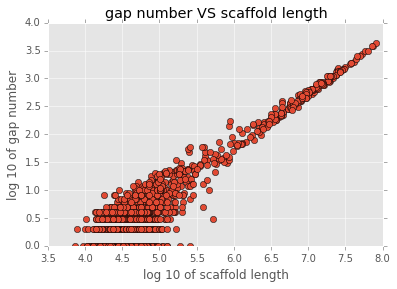

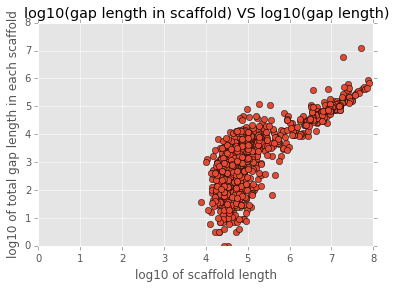

In [18]:
from scipy.stats.stats import pearsonr  
merge_gap_fn = folder + '/05_all_gap.txt'
if os.path.exists(merge_gap_fn):
    gap_df = pd.read_csv(merge_gap_fn,sep='\t',header=0)
    # gap number vs scaffold length
    gap_num_df = pd.DataFrame(Counter(gap_df['ref']).items(),columns=['chr','num'])
    chr_len_df = pd.read_csv(chr_len_fn,sep='\t',header=None,usecols=[0,1],names=['chr','len'])
    num_len_df = pd.merge(gap_num_df,chr_len_df,on='chr',how='inner')
    _ = plt.figure()
    _ = plt.plot(np.log10(num_len_df['len']),np.log10(num_len_df['num']),'o')
    _ = plt.title('gap number VS scaffold length')
    _ = plt.xlabel('log 10 of scaffold length')
    _ = plt.ylabel('log 10 of gap number')
    plt.savefig(folder+'/f04_gap_num_VS_scaf_len.png',dpi=600)
    print 'pearson correlation of gap number and scaffold length',
    pearsonr(np.log10(num_len_df['len']),np.log10(num_len_df['num']))
    # gap length vs scaffold length
    gap_len_dic = {}
    for c,s,e in zip(gap_df['ref'],gap_df['r_s'],gap_df['r_e']):
        if c in gap_len_dic:
            gap_len_dic[c] |= set(range(int(s)+1,int(e)+1))
        else:
            gap_len_dic[c] = set()
    for key in gap_len_dic:
        gap_len_dic[key] = len(gap_len_dic[key])
    gap_len_dic2df = pd.DataFrame(gap_len_dic.items())
    gap_len_dic2df.columns=['chr','ref_glen']
    len_len_df = pd.merge(gap_len_dic2df,chr_len_df,on='chr',how='inner')
    _ = plt.figure()
    _ = plt.plot(np.log10(len_len_df['len']),np.log10(len_len_df['ref_glen']),'o')
    _ = plt.title('log10(gap length in scaffold) VS log10(gap length)')
    _ = plt.xlabel('log10 of scaffold length')
    _ = plt.ylabel('log10 of total gap length in each scaffold')
    _ = plt.xlim([0,8])
    plt.savefig(folder+'/f05_gap_len_VS_scaf_len.png',dpi=600)
    plt.show()

#### From the second figure above, we can see that some scaffolds' gap length almost equal to the whole length of the scaffolds. These cases are caused by the case 3 in the strategy figure, which indicates that  gaps are very long in picr but short in hamster.
#### So next we plot distribution of length difference between picr and hamster.

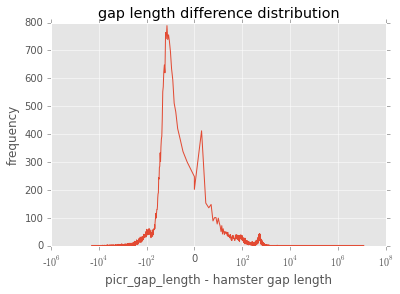

In [19]:
import collections as clcs
gap_pos_fn = folder + '/03_gap_pos.txt'
if os.path.exists(gap_pos_fn):
    gap_df = pd.read_csv(gap_pos_fn,header=0,sep='\t')
    gap_df = gap_df[gap_df['gap_type'].isin(['gap length is too different','gap length is similar'])]
    gap_df = gap_df.reset_index(drop=True)
    gap_df['r_len'] = gap_df['r_e']-gap_df['r_s']
    gap_df['diff'] = gap_df['r_len'] - gap_df['q_len']
    diff_c_dic = clcs.Counter(gap_df['diff'])
    pos = sorted(diff_c_dic.keys())
    count = [diff_c_dic[k] for k in pos]
    log_pos = []
    for k in pos:
        if k > 0:
            log_pos.append(np.log10(k))
        elif k == 0:
            log_pos.append(0)
        elif k <0:
            log_pos.append(-np.log10(-k))
    # plot figures
    fig, ax =plt.subplots()
    fig.canvas.draw()
    _ = ax.plot(log_pos,count)
    _ = ax.set(title='gap length difference distribution',
              ylabel='frequency',xlabel='picr_gap_length - hamster gap length')
    # set xticks
    labels = ax.get_xticks().tolist()
    new_labels = []
    for label in labels:
        l = int(float(label))
        if l < 0:
            new_labels.append('-$10^'+str(-l)+'$')
        elif l > 0:
            new_labels.append('$10^'+str(l)+'$')
        else:
            new_labels.append(l)
    _ = ax.set_xticklabels(new_labels)
    plt.savefig(folder + '/f03_gap_len_diff_distribution.png',dpi=300)

#### The figure above shows that most of the mapping gaps between hamster and picr differ less than 100 bps. Usually variant larger than 1000 bps is considered structure variation. So here we use 1000 as threshold to filter gaps.

In [40]:
merge_gap_fn = folder + '/05_all_gap.txt'
filter_gap_fn = folder + '/06_filter_all_gap.txt'
if not os.path.exists(filter_gap_fn):
    df = pd.read_csv(merge_gap_fn,sep='\t',header=0)
    df['diff'] = df['super_end']-df['super_start']-(df['q_s']-df['q_e'])
    df = df[(-1000 <= df['diff']) & (df['diff']<=1000)]
    del df['diff']
    df.to_csv(filter_gap_fn,sep='\t',index=False)

### 6. After getting the gap regions, next step is to process the vcf files. We need to get variants that are only in target samples, not in controls, and then extract variants in the gap region. For reference, snp and insertion both can be represented by one position, but deletion need to be represened using a region. So we represented all varaints using regions and then get intersection with gap region.

* 1. filter out variants in variants

In [6]:
ctrl_vcf =  VCF_path + '/control_vcf/hamsterDNA2newAssembly.merged.filter.vcf'
#===============================================================================
#                     4. filter variants using control gene variant statistics
#===============================================================================
def vari_type(row):
    '''decide variation type for function get_vcf_num_in_gap'''
    if len(row['REF']) == len(row['ALT']):
        return 'snp'
    elif len(row['REF']) > len(row['ALT']):
        return 'del'
    elif len(row['REF']) < len(row['ALT']):
        return 'ins'
    
def vcf_stats(vcf):
    dic = {'snp':0,'ins':0,'del':0}
    for line in open(vcf):
        if line.startswith('#'):
            continue
        else:
            item = line.strip().split('\t')
            if len(item[3]) == len(item[4]):
                dic['snp'] += 1
            elif len(item[3]) > len(item[4]):
                dic['del'] += 1
            elif len(item[3]) < len(item[4]):
                dic['ins'] += 1
    return dic

def remove_control_vcf(vcf,control,out_pre):
    '''remove the control variants in the sample varaints
    * vcf: target vcf results
    * control: vcf results called using its own DNAseq
    '''
    cmd = ('vcftools --vcf {vcf} --diff {control} --out {pre}').format(vcf=vcf,control=control,pre=out_pre)
#     print(cmd);sys.stdout.flush()
    sarge.run(cmd)

def get_vcf_in_gap(merge_gap_fn,diff_vcf,vcf_in_gap_fn):
    '''get variants in gap region
    * merge_gap_fn: has all gaps in qry ref and super ref
    * diff_vcf: varaint file only in qry
    * vcf_in_gap_fn: output store gap and varaints
    '''
    gap_df = pd.read_csv(merge_gap_fn,sep='\t',header=0)
    gap_df = gap_df[gap_df['super_start']<gap_df['super_end']]
    columns = ['super_chr','super_start','super_end',\
                    'qry','q_s','q_e','ref','r_s','r_e','gap_type']
    gap_bed = BedTool.from_dataframe(gap_df[columns])
    diff_vcf_df = pd.read_csv(diff_vcf,sep='\t',usecols=[0,1,3,4,6],names=['ref','POS','file','REF','ALT'])
    qry_vcf_df = diff_vcf_df[diff_vcf_df['file'].values == '1']
    qry_vcf_df = qry_vcf_df.reset_index(drop=True)
    qry_vcf_df['vcf_type'] = qry_vcf_df[['REF','ALT']].apply(lambda row: vari_type(row),axis=1)
    qry_vcf_df['v_s'] = qry_vcf_df['POS'].astype('int')-1
    qry_vcf_df['v_e'] = qry_vcf_df[['v_s','REF','vcf_type']].apply(lambda row:int(row['v_s'])+len(row['REF']) \
                                                if row['vcf_type']=='del' else int(row['v_s'])+1,axis=1)
    # get intersection
    vcf_bed = BedTool.from_dataframe(qry_vcf_df[['ref','v_s','v_e','vcf_type']])
    inter_bed = vcf_bed.intersect(gap_bed,wo=True)
    columns = ['vcf_ref','vcf_start','vcf_end','vcf_type','gap_ref','gap_start','gap_end',\
                        'qry','q_s','q_e','ref','ref_s','ref_e','gap_type','len']
    inter_df = inter_bed.to_dataframe(names=columns)
    inter_df.to_csv(vcf_in_gap_fn,sep='\t',index=False)
    return inter_df

* 1. Get variants in gap regions.  2. then get variants in cds regions.

In [9]:
%%time
# don't forget to compile the function ref_gap2super_gap if you only want to run this part
test_vcf_paths = [p for p in natsorted(glob.glob(VCF_path+'/test_vcf/*')) if os.path.isdir(p)]
filter_gap_fn = folder + '/06_filter_all_gap.txt'
for test_path in test_vcf_paths:
    vcf = glob.glob(test_path + '/*.vcf')
    if vcf == []:
        out_pre = glob.glob(test_path + '/*.diff.sites_in_files')[0][:-20]
    else:
        out_pre = test_path + '/' + vcf[0].split('/')[-1].split('.')[0]
    # filter out control vcfs
    diff_vcf = out_pre + '.diff.sites_in_files'
    if not os.path.exists(diff_vcf):
        remove_control_vcf(vcf[0],ctrl_vcf,out_pre)
    # get varaints in gap regions
    vcf_in_gap_fn = out_pre+'_vcf_in_gap.txt'
    if not os.path.exists(vcf_in_gap_fn):
        inter_df = get_vcf_in_gap(filter_gap_fn,diff_vcf,vcf_in_gap_fn)
    # get gap variants in cds gap region
    vcf_in_cds_fn = out_pre+'_vcf_in_cds_gff.txt'
    if not os.path.exists(vcf_in_cds_fn):
        gap_vcf_df = pd.read_csv(vcf_in_gap_fn,sep='\t',header=0,low_memory=False)
        gap_vcf_bed = BedTool.from_dataframe(gap_vcf_df[['vcf_ref','vcf_start','vcf_end','vcf_type']])
        gff_df = pd.read_csv(new_gff,sep='\t',header=None,comment='#',names=['ref','s','f','r_s','r_e','q','str','n2','anno'])
        cds_df = gff_df[gff_df['f'].values=='CDS']
        cds_df = cds_df.reset_index(drop=True)
        # define new genome to super genome dictionary
        ref_super_dic = {}
        for line in open(ref_super_pos_map):
            item = line.strip().split('\t')
            ref_super_dic[item[3]] = item[:2]
        cds_df[['super_chr','super_start','super_end']] = cds_df.apply(lambda row: pd.Series(ref_gap2super_gap(row,ref_super_dic)),axis=1)
        cds_bed = BedTool.from_dataframe(cds_df[['super_chr','super_start','super_end','anno']])
        cds_vcf_df = (gap_vcf_bed.intersect(cds_bed,wo=True)).to_dataframe()
        cds_vcf_df.columns = ['v_ref','v_s','v_e','vcf_type','cds_ref','cds_s','cds_e','anno','len']
        cds_vcf_df.to_csv(vcf_in_cds_fn,sep='\t',index=False)

CPU times: user 6min 53s, sys: 18.7 s, total: 7min 12s
Wall time: 7min 50s


### 7. Next we will get statistics of variants, count how many mutations are in each category

In [10]:
%%time
test_vcf_paths = [p for p in natsorted(glob.glob(VCF_path+'/test_vcf/*')) if os.path.isdir(p)]
stat_df = pd.DataFrame()
for test_path in test_vcf_paths:
    stat = []
    # total number of variants, control number and filterred number
    diff_vcf = glob.glob(test_path+'/*.diff.sites_in_files')[0]
    vcf_in_gap_fn = glob.glob(test_path+'/*_vcf_in_gap.txt')[0]
    vcf_in_cds_fn = glob.glob(test_path+'/*_in_cds_gff.txt')[0]
    if os.path.exists(vcf_in_gap_fn) and os.path.exists(diff_vcf):
        diff_vcf_df = pd.read_csv(diff_vcf,sep='\t',header=0,usecols=[0,3,4,6],names=['CHROM','IN_FILE','REF','ALT'])
        ctrl_vcf_df = diff_vcf_df[diff_vcf_df['IN_FILE'].isin(['B'])]
        filt_vcf_df = diff_vcf_df[diff_vcf_df['IN_FILE'].isin(['1'])]
        total = ctrl_vcf_df.shape[0] + filt_vcf_df.shape[0]
        stat.extend([total,ctrl_vcf_df.shape[0],filt_vcf_df.shape[0]])
        # snp, indel number after filter
        filt_vari_c = {'snp':0,'ins':0,'del':0}
        for ref,alt in zip(filt_vcf_df['REF'],filt_vcf_df['ALT']):
            if len(ref) == len(alt):
                filt_vari_c['snp'] += 1
            elif len(ref) > len(alt):
                filt_vari_c['del'] += 1
            elif len(ref) < len(alt):
                filt_vari_c['ins'] += 1
        stat.extend([filt_vari_c['snp'],filt_vari_c['ins'],filt_vari_c['del']])
        # snp, indel in gap region
        vcf_in_gap_df = pd.read_csv(vcf_in_gap_fn,sep='\t',header=0,usecols=[0,1,2,3])
        vcf_gap_dic = Counter((vcf_in_gap_df.drop_duplicates())['vcf_type'])
        stat.extend([vcf_gap_dic['snp'],vcf_gap_dic['ins'],vcf_gap_dic['del']])
        # snp, indel in cds region
        vcf_in_cds_df = pd.read_csv(vcf_in_cds_fn,sep='\t',header=0,usecols=[0,1,2,3])
        vcf_cds_dic = Counter(vcf_in_cds_df.drop_duplicates()['vcf_type'])
        stat.extend([vcf_cds_dic['snp'],vcf_cds_dic['ins'],vcf_cds_dic['del']])
        stat_df[test_path.split('/')[-1]] = pd.Series(stat)
stat_df.index=['total_var','control_var','filter_var','filter_snp','filter_ins','filter_del',
              'gap_snp','gap_ins','gap_del','cds_snp','cds_ins','cds_del']
stat_df.to_csv(folder+'/07_vcf_stat.txt',sep='\t')
display(stat_df)

,1D9,1D9_3mon,C0101,CHOS,CHOpr,DG44,ECACC,FCS2,K1_6mon,K1_SF,MCB,no_gln,pgsa
total_var,5901401,5894448,5566074,4663123,5042526,4727716,5025295,5948137,5548170,5049364,5813705,5833668,5693728
control_var,1133805,1138751,1050577,861231,896154,852616,879678,1122569,993010,889065,1072086,1061842,1052383
filter_var,4767596,4755697,4515497,3801892,4146372,3875100,4145617,4825568,4555160,4160299,4741619,4771826,4641345
filter_snp,3727231,3725799,3629854,3120614,3394811,3190921,3383881,3849415,3612053,3409772,3758389,3781099,3764166
filter_ins,518096,511587,428353,327492,363120,326771,369174,481742,467250,361985,480580,491032,426252
filter_del,522269,518311,457290,353786,388441,357408,392562,494411,475857,388542,502650,499695,450927
gap_snp,19386,19052,15623,11327,12285,11389,12210,18778,17404,12430,17797,18773,15924
gap_ins,3969,3684,1828,999,1158,987,1220,3201,3175,1141,3407,3506,1788
gap_del,4455,4387,2966,1671,1991,1659,2133,3745,3748,2015,4000,4025,2923
cds_snp,303,290,259,199,195,168,186,293,274,188,285,310,249


CPU times: user 1min 12s, sys: 54.6 s, total: 2min 7s
Wall time: 2min 8s


#### After getting the numbers, we still don't know how they affect the research using the old genome. So next we see which genes have mutations in the gaps and do GO term analysis for those genes. This means if people use old genome to do the pathway analysis, they will miss these pathway/GO terms.

In [37]:
def get_gene_id_name_dic(gff):
    # get gene id and gene name mapping
    g_id_name_dic = {}
    new_gff_df = pd.read_csv(gff,sep='\t',header=None,comment='#',usecols=[0,2,8],names=['chr','feature','anno'])
    new_gff_df = new_gff_df[new_gff_df['feature'].values=='gene']
    new_gff_df = new_gff_df.reset_index(drop=True)
    for anno in new_gff_df['anno']:
        gid = re.search('(?<=ID=).+?(?=;)',anno).group(0)
        try:
            gnm = re.search('(?<=Similar to ).+?(?=:)',anno).group(0)
            g_id_name_dic[gid] = gnm
        except:
            g_id_name_dic[gid] = ''
    return g_id_name_dic

def human_gene_name2id(fn,idfn):
    '''
    this function transfer human gene names to gene id
    * fn: a file with a list of gene name
    * idfn: file name has human gene id and name
    '''
    id_df = pd.read_csv(idfn,sep='\t',header=None,names=['id','name','chr'])
    id_df['id'] = id_df['id'].map(lambda x: x.split('.')[0])
    name_id_dic = id_df.set_index('name')['id'].to_dict()
    df = pd.read_csv(fn,sep='\t',header=0,names=['geneid'])
    genes = df['geneid'].tolist()
    new_genes = []
    for g in genes:
        upper_g = ''
        for l in g:
            if l.isalpha():
                upper_g += l.upper()
            else:
                upper_g += l
        try:
            new_genes.append(name_id_dic[upper_g])
        except:
            continue
            #new_genes.append(upper_g)
    with open(fn[:-9]+'.txt','w') as f:
        f.write('\n'.join(new_genes))

* Get genes that have mutations in coding gaps

In [38]:
%%time
test_vcf_paths = [p for p in natsorted(glob.glob(VCF_path+'/test_vcf/*')) if os.path.isdir(p)]
# get cds with gaps
gene_vcf_gap = []
g_id_name_dic = get_gene_id_name_dic(new_gff)
for test_path in test_vcf_paths:
    vcf_in_cds_fn = glob.glob(test_path+'/*_in_cds_gff.txt')[0]
    if os.path.exists(vcf_in_cds_fn):
        vcf_in_cds_df = pd.read_csv(vcf_in_cds_fn,sep='\t',header=0,usecols=[7])
        gid_lst = vcf_in_cds_df['anno'].map(lambda x: re.search('(?<=ID=).+?(?=-)',x).group(0)).tolist()
        gene_vcf_gap.extend(gid_lst)
gene_vcf_gap = list(set(gene_vcf_gap))
print(len(gene_vcf_gap))
gene_vcf_gap_names = list(set([g_id_name_dic[g] for g in gene_vcf_gap]))
print len(gene_vcf_gap_names),'genes that have mutation in their coding gap regions'
gene_vcf_gap_fn = folder+'/07_gene_vcf_cds_gap_name.txt'
with open(gene_vcf_gap_fn,'w') as f:
    f.write('\n'.join(gene_vcf_gap_names))
# transfer gene name to gene id
human_gene_name2id(gene_vcf_gap_fn,human_id_fn)

244
158 genes that have mutation in their coding gap regions
CPU times: user 936 ms, sys: 28 ms, total: 964 ms
Wall time: 963 ms


#### The above gene list has some unique mouse genes that cannot be converted to human gene ids

* Get genes that have gaps in their coding region

In [39]:
%%time
# find all genes whose CDS overlap with gap
merge_gap_fn = folder+'/05_all_gap.txt'
if os.path.exists(merge_gap_fn):
    # read all cds regions
    gff_df = pd.read_csv(new_gff,sep='\t',header=None,comment='#',names=['ref','s','f','r_s','r_e','q','str','n2','anno'])
    cds_df = gff_df[gff_df['f'].values=='CDS']
    cds_df = cds_df.reset_index(drop=True)
    cds_bed = BedTool.from_dataframe(cds_df[['ref','r_s','r_e','anno']])
    # get all gaps
    gap_df = pd.read_csv(merge_gap_fn,sep='\t',header=0,usecols=range(3,6))
    gap_bed = BedTool.from_dataframe(gap_df)
    names=['gap_chr','gap_s','gap_e','chr','s','e','anno','len']
    gap_cds_df = gap_bed.intersect(cds_bed,wo=True).to_dataframe(names=names)
    gene_gap_lst = gap_cds_df['anno'].map(lambda x:re.search('(?<=ID=).+?(?=-)',x).group(0)).tolist()
    gene_gap_names = [g_id_name_dic[g] for g in list(set(gene_gap_lst))]
print len(gene_gap_names),'genes that have gaps in their coding regions'
gene_gap_fn = folder +'/08_gene_cds_gap_name.txt'
with open(gene_gap_fn,'w') as f:
    f.write('\n'.join(gene_gap_names))
human_gene_name2id(gene_gap_fn,human_id_fn)

2699 genes that have gaps in their coding regions
CPU times: user 1.47 s, sys: 68 ms, total: 1.54 s
Wall time: 1.99 s


#### The following shows an example of a mutation in pgsa cell line, which has a mutation that yields virus resistant feature.

In [2]:

path = '/data/shangzhong/DE/picr_pgsa'
bams = [f for f in os.listdir(path) if f.endswith('.bam')]
array = [[] for x in range(4)]
for bam in bams:
    bam_h = pysam.AlignmentFile(path+'/'+bam,'rb')
    count = bam_h.count_coverage(reference='picr_155',start=1887691,end=1887692,quality_threshold=15)
    total = np.sum(count)
    if total==0:
        array[0].append(0)
        array[1].append(0)
        array[2].append(0)
        array[3].append(0)
    else:
        array[0].append(count[0][0]/float(total))
        array[1].append(count[1][0]/float(total))
        array[2].append(count[2][0]/float(total))
        array[3].append(count[3][0]/float(total))

In [3]:
indexes = [f.split('.')[0] for f in bams]
bam_count = pd.DataFrame({'A':array[0],'C':array[1],'G':array[2],'T':array[3]},index=indexes)
samples = ['pgsa','CHOS','FCS','PF-MCB','PF-6mon','1D9-MCB','1D9-3mon','no-gln']
bam_count = bam_count.loc[samples,:]

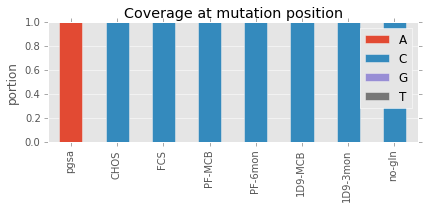

In [6]:
ax = bam_count.plot.bar(stacked=True,figsize=(6,3))
_ = ax.set_title('Coverage at mutation position')
_ = ax.set_ylabel('portion')
_ = ax.set_ylim([0,1])
plt.tight_layout()
plt.savefig('/data/shangzhong/DE/picr_pgsa/mutation_cov.svg',dpi=300)